This notebooks uses the same synthetic data as it is generated in the experiment 1 with Mixture Density Networks (MDN)

The hypothesis is that MDN will be capable of modelling the uncertainty better since it makes less assumptions about the initial
data distribution. One key assumption that it is violated using the technique in experiment 1 is that the initial data distribution of y is unimodal which is not true.

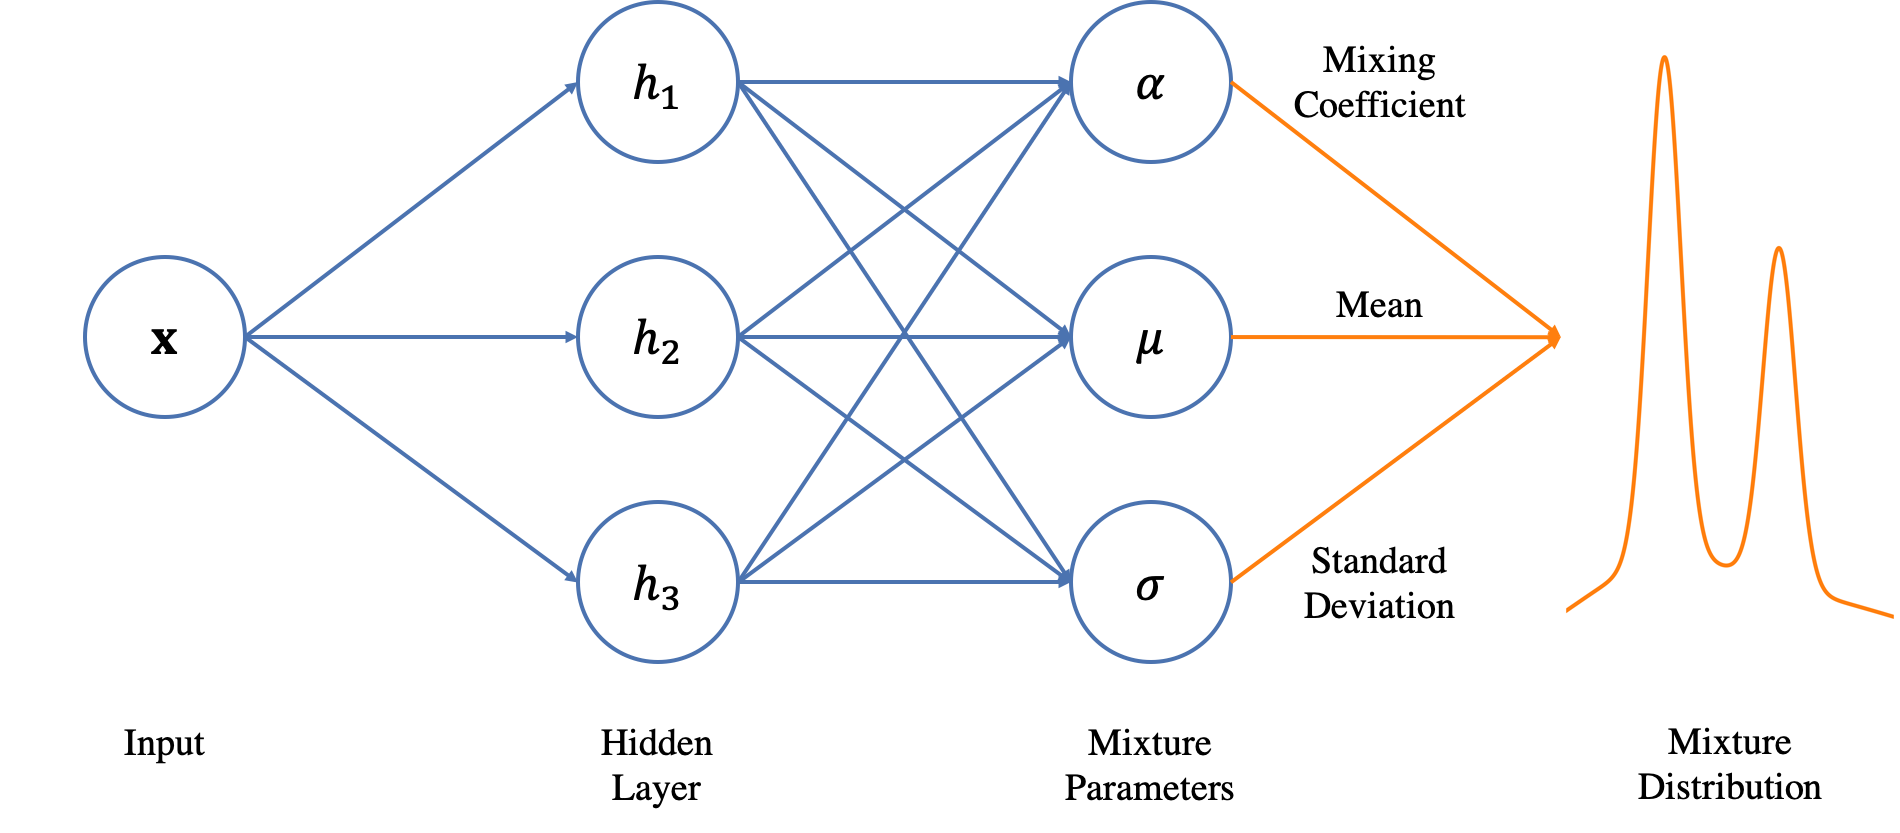

In [1]:
from IPython.display import Image
Image("graphics/MDN_Layout.png")

#### Imports

In [2]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as K
from tensorflow_probability import distributions as tfd
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

import seaborn as sns

%matplotlib inline

#### Generate the synthetic data of the Experiment 1

In [3]:
# Generate some linearly related data
np.random.seed(2019)

n_samples = 10000
x_ = np.random.random(n_samples)

sin_ = 0.4 * np.sin(x_*4*np.pi)
eps = np.random.normal(scale=1.0, size=n_samples) * sin_ # noise
y_1 = 2*x_ + 1 
y_ = y_1 + eps # linear data with noise

#### Describe the generated data

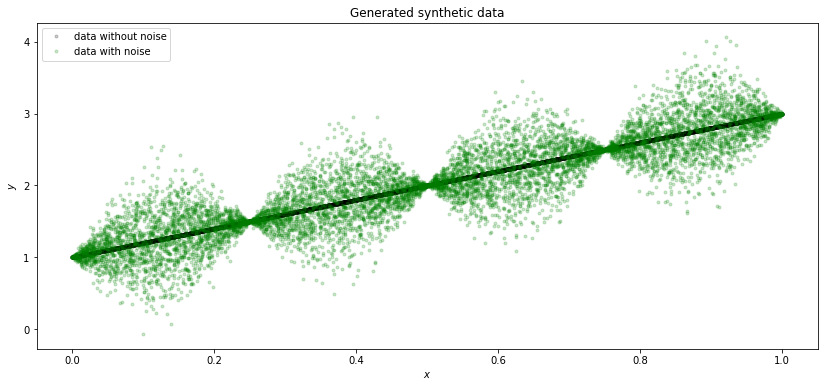

In [4]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Generated synthetic data')

# plot data (with and without noise addition) 
plt.plot(x_, y_1, '.', alpha=0.2, color='black' ) 
plt.plot(x_, y_, '.', alpha=0.2, color='green' ) 

plt.legend([r'data without noise',r'data with noise', r'$\mu$', r'$\pm\sigma$'])
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

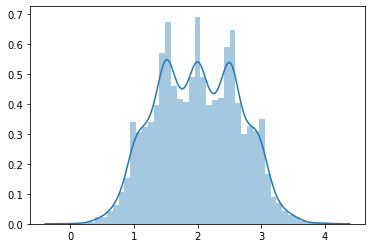

In [5]:
sns.distplot(y_)

As we can see here, the distribution is multimodal.

#### Validation and training

In [6]:
# Split into training and validation sets
n_validation = 800
x_val, x_train = x_[:n_validation].reshape(-1,1), x_[n_validation:].reshape(-1,1)
y_val, y_train = y_[:n_validation].reshape(-1,1), y_[n_validation:].reshape(-1,1)

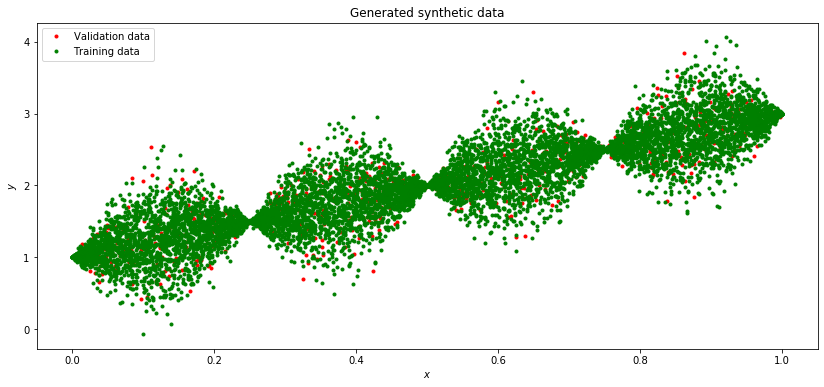

In [7]:
# Plot the data
plt.figure(figsize=(14,6))
plt.title('Generated synthetic data')

# plot data (with and without noise addition) 
plt.plot(x_val, y_val, '.', color='red' ) 
plt.plot(x_train, y_train, '.', color='green' ) 

plt.legend([r'Validation data',r'Training data', r'$\mu$', r'$\pm\sigma$'])
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

### Mixture Density Network

In [8]:
class MDN(tf.keras.Model):

    def __init__(self, neurons=1000, components = 2):
        super(MDN, self).__init__(name="MDN")
        self.neurons = neurons
        self.components = components
        
        self.h1 = Dense(neurons, activation="relu", name="h1")
        self.h2 = Dense(neurons, activation="relu", name="h2")
        
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, name="mus")
        self.sigmas = Dense(components, activation="nnelu", name="sigmas")
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x = self.h1(inputs)
        x = self.h2(x)
        
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v, mu_v, sigma_v])
    

In [9]:
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1)*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha, mu, sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    
    log_likelihood = gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y
    
    return -tf.reduce_mean(log_likelihood, axis=-1)

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

In [10]:
no_parameters = 3
components = 1
neurons = 1000

opt = tf.train.AdamOptimizer(1e-3)

tf_path = os.path.join(os.getcwd(), 'tf_board')

tensorboard = TensorBoard(log_dir=tf_path, histogram_freq=0, write_graph=True, write_images=False)
mon = EarlyStopping(monitor='val_loss', baseline=-0.1, mode='min')

In [11]:
mdn = MDN(neurons=neurons, components=components)
mdn.compile(loss=gnll_loss, optimizer=opt)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
x_train.shape, x_val.shape

((9200, 1), (800, 1))

### Train the MDN with the synthetic data

In [14]:
%%time
mdn.fit(x=x_train, y=y_train, epochs=1000, validation_data=(x_val, y_val), callbacks=[tensorboard], batch_size=128, verbose=0)

Wall time: 5min 32s


### Get predictions for validation set

In [15]:
y_pred = mdn.predict(x_val)
alpha_pred, mu_pred, sigma_pred = slice_parameter_vectors(y_pred)

In [27]:
mu_pred.shape

(800, 1)

### Plot results

C:\Users\yolan\Anaconda3\envs\deep_learning_keras\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  
C:\Users\yolan\Anaconda3\envs\deep_learning_keras\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


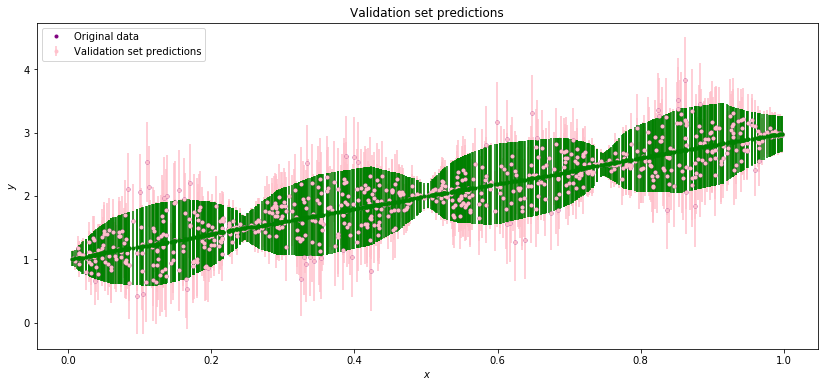

In [17]:
# Plot predictions and their errors
import numpy as np 

fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(x_val, y_val, '.', color='purple')
ax1.errorbar(x_val, y_val, yerr=np.sqrt(sigma_pred) , color='pink', fmt='.'); 
ax1.errorbar(x_val, mu_pred, yerr=np.sqrt(sigma_pred) , color='green', fmt='.'); 

# One standard-deviation envelope
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data','Validation set predictions'], loc='upper left', );

### Evaluate the results

In [52]:
from utilities import validation_metrics

In [47]:
x_val = x_val.reshape(-1)
y_val =  y_val.reshape(-1)
mu_pred = mu_pred.reshape(-1)
sigma_pred = sigma_pred.reshape(-1)

Global model performance: 

- R2 y_hat: 0.7819513629934763 
- RMSE y_hat: 0.08849866398283338 
- RMSE sigma_hat: 0.12054303020919313 

Extreme values performance:
 
- Upper bound - 164 Y pts  +sigma 0.33: 

R2 y_hat: 0.1830778421013794
RMSE y_hat: 1.033104942442236
MAE sigma_hat : 0.986768764838634
-
 Lower bound - 157 Y pts -sigma 0.33: 

R2 y_hat: 0.024241261472532916
RMSE y_hat: 1.0351223720644478
MAE sigma_hat: 0.988021682127532
-
 In bound - 479 Y pts in [+sigma 0.33,-sigma 0.3333333333333333]: 

R2 y_hat: 0.5925921715582289
RMSE y_hat: 0.5165883220728926
MAE sigma_hat: 1.0046521271003415


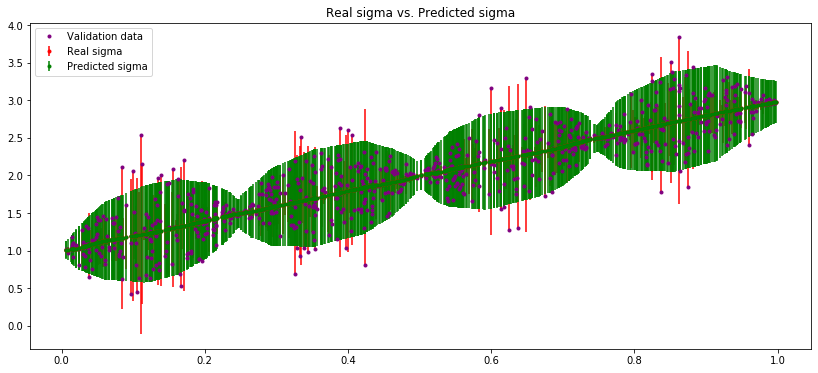

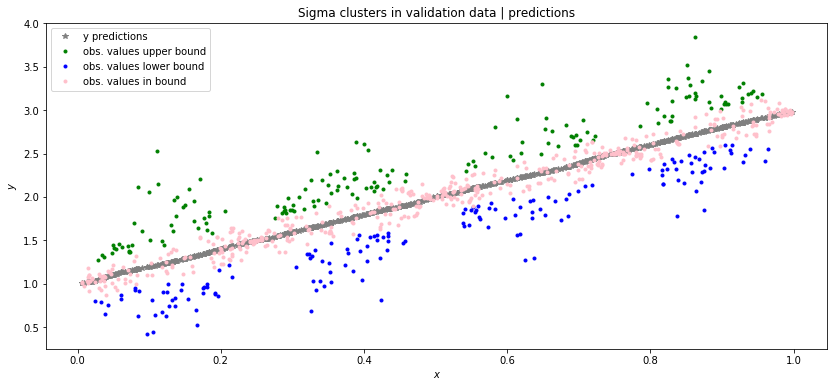

In [51]:
validation_metrics.overall_model_performance(x_val, y_val, mu_pred, sigma_pred, std_factor=1/3, extreme_values_performance=True, display_plots=True)